##### Training Objective:

The goal of this loop is to train the small network to re-embed RoBERTa’s output embeddings in such a way that concept-related information is minimized.
This is achieved by making the concept classifier's predictions approach a uniform distribution using KL divergence as the loss.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2, 3"

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from transformers import AutoTokenizer, AutoModel, RobertaModel
from datasets import Dataset
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split, TensorDataset
import nbimporter
from concept_classification import ConceptClassifier

In [2]:
# Use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
print(f"Using device: {device}")

Using device: cuda:0


In [3]:
# Load RoBERTa Model and Tokenizer
roberta_model = RobertaModel.from_pretrained("roberta-base").to(device)
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
class SmallNetwork(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        """
        Small network to re-embed RoBERTa output.
        
        Args:
        - input_dim (int): Dimensionality of RoBERTa's output embeddings.
        - bottleneck_dim (int): Dimensionality of the bottleneck layer.
        """
        super(SmallNetwork, self).__init__()
        self.project = nn.Linear(input_dim, bottleneck_dim)
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=bottleneck_dim, nhead=4, batch_first=True)
        self.expand = nn.Linear(bottleneck_dim + input_dim, input_dim)  # Adjust for concatenation
        self.layer_norm = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(p=0.2)
        self.activation = nn.GELU()

    def forward(self, x):
        """
        Forward pass for the small network.
        
        Args:
        - x (torch.Tensor): Input embeddings from RoBERTa (batch_size x input_dim).
        
        Returns:
        - torch.Tensor: Re-embedded representation (batch_size x input_dim).
        """
        identity = x  # Save original input for residual connection

        # Project and transform input
        x = self.project(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.transformer_layer(x)

        # Concatenate residual and transformed outputs
        x = torch.cat([x, identity], dim=-1)  # Concatenate along feature dimension
        x = self.expand(x)  # Reduce to original dimensionality
        x = self.layer_norm(x)  # Normalize the output
        return x


In [5]:
class InverseNetwork(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        """
        Inverse network to reconstruct original embeddings from re-embedded outputs.
        
        Args:
        - input_dim (int): Dimensionality of original embeddings.
        - bottleneck_dim (int): Dimensionality of bottleneck embeddings.
        """
        super(InverseNetwork, self).__init__()
        self.project = nn.Linear(input_dim, bottleneck_dim)
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=bottleneck_dim, nhead=4, batch_first=True)
        self.expand = nn.Linear(bottleneck_dim + input_dim, input_dim)  # Adjust for concatenation
        self.layer_norm = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(p=0.2)
        self.activation = nn.GELU()

    def forward(self, x):
        """
        Forward pass for the inverse network.
        
        Args:
        - x (torch.Tensor): Re-embedded embeddings (batch_size x seq_length x input_dim).
        
        Returns:
        - torch.Tensor: Reconstructed original embeddings (batch_size x seq_length x input_dim).
        """
        identity = x  # Save original input for residual connection

        # Project and transform input
        x = self.project(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.transformer_layer(x)

        # Concatenate residual and transformed outputs
        x = torch.cat([x, identity], dim=-1)  # Concatenate along feature dimension
        x = self.expand(x)  # Reduce to original dimensionality
        x = self.layer_norm(x)  # Normalize the output
        return x


In [6]:
def kl_uniform_loss(logits, num_classes, epsilon=1e-9):
    """
    Compute KL divergence between predicted logits and a uniform distribution.
    
    Args:
    - logits (torch.Tensor): Output logits from the concept classifier (batch_size x num_classes).
    - num_classes (int): Number of concept classes.
    
    Returns:
    - torch.Tensor: KL divergence loss.
    """
    # Convert logits to probabilities using softmax
    probs = F.softmax(logits, dim=-1) + epsilon  # Add epsilon to avoid log(0)
    
    # Define uniform target distribution
    uniform_dist = torch.full_like(probs, 1.0 / num_classes)
    
    # Compute KL divergence
    kl_loss = F.kl_div(probs.log(), uniform_dist, reduction='batchmean')  # Log probabilities are required
    return kl_loss


In [7]:
def combined_loss(kl_loss, original, reconstructed, lambda_reconstruction=0.1):
    """
    Combine KL divergence loss with reconstruction loss.
    
    Args:
    - kl_loss (torch.Tensor): KL divergence loss.
    - original (torch.Tensor): Original embeddings.
    - reconstructed (torch.Tensor): Reconstructed embeddings.
    - lambda_reconstruction (float): Weight for reconstruction loss.
    
    Returns:
    - torch.Tensor: Combined loss.
    """
    reconstruction_loss = F.mse_loss(reconstructed, original)
    return kl_loss + lambda_reconstruction * reconstruction_loss


In [8]:
# Load data from CSV
data_path = "imbalanced_concepts.csv"  # Replace with your CSV path
data = pd.read_csv(data_path)

In [9]:
# Tokenize and process data
def tokenize_data(reviews):
    tokenized_data = tokenizer(reviews, padding=True, truncation=True, max_length=512, return_tensors="pt")
    input_ids = tokenized_data["input_ids"]
    attention_mask = tokenized_data["attention_mask"]
    return TensorDataset(input_ids, attention_mask)

In [11]:
# Prepare datasets
dataset = tokenize_data(data['clean_text'].tolist())
data_size = len(dataset)
train_size = int(0.8 * data_size)
val_size = data_size - train_size

train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [12]:
# Load pretrained Concept Classifier
concept_classifier = ConceptClassifier(num_labels=2).to(device)
concept_classifier.load_state_dict(torch.load("concept_classifier.pt"))
concept_classifier.eval()  # Freeze concept classifier during small network training

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_2936066/1009610697.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We r

ConceptClassifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm

In [13]:
# Initialize networks
small_network = SmallNetwork(input_dim=768, bottleneck_dim=384).to(device)
inverse_network = InverseNetwork(input_dim=768, bottleneck_dim=384).to(device)

In [14]:
def init_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)

# Apply initialization
small_network.apply(init_weights)
inverse_network.apply(init_weights)

InverseNetwork(
  (project): Linear(in_features=768, out_features=384, bias=True)
  (transformer_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
    )
    (linear1): Linear(in_features=384, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=384, bias=True)
    (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (expand): Linear(in_features=1152, out_features=768, bias=True)
  (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (activation): GELU(approximate='none')
)

In [15]:
# Optimizers
small_network_optimizer = optim.AdamW(small_network.parameters(), lr=0.0003)
inverse_network_optimizer = optim.AdamW(inverse_network.parameters(), lr=0.0003)

##### Validation and Evaluation 
Concept labels can be used indirectly to measure how well the small network has removed concept information. The key metric will be the concept classifier’s accuracy on the re-embedded outputs. If the accuracy is low, it indicates that the small network has successfully removed concept information.

In [17]:
# Early Stopping and Metrics
patience = 3
best_val_loss = float("inf")
best_model_state = None
wait = 0

train_losses = []
val_losses = []

roberta_model.eval()

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    small_network.train()
    inverse_network.train()
    total_train_loss = 0

    # Training Phase
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
        input_ids, attention_mask = [x.to(device) for x in batch]

        # Forward pass through RoBERTa
        with torch.no_grad():
            roberta_output = roberta_model(input_ids=input_ids, attention_mask=attention_mask)
            roberta_embeddings = roberta_output.last_hidden_state

        # Pass through Small Network
        reembedded_output = small_network(roberta_embeddings)

        # Train Inverse Network
        reconstructed_output = inverse_network(reembedded_output.detach())  # Detach reembedded_output
        inverse_network_optimizer.zero_grad()
        reconstruction_loss = F.mse_loss(reconstructed_output, roberta_embeddings)  # Original embeddings
        reconstruction_loss.backward()
        inverse_network_optimizer.step()

        # Compute KL divergence loss
        logits = concept_classifier(input_ids=None, attention_mask=None, embeddings=reembedded_output, return_probs=False)
        kl_loss = kl_uniform_loss(logits, num_classes=2)

        # Combine losses for Small Network
        total_loss = combined_loss(kl_loss, roberta_embeddings, reconstructed_output.detach())  # Detach reconstructed_output

        # Backpropagation for Small Network
        small_network_optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(small_network.parameters(), max_norm=1.0)
        small_network_optimizer.step()

        total_train_loss += total_loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Phase
    small_network.eval()
    inverse_network.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation"):
            input_ids, attention_mask = [x.to(device) for x in batch]

            # Forward pass through RoBERTa
            roberta_output = roberta_model(input_ids=input_ids, attention_mask=attention_mask)
            roberta_embeddings = roberta_output.last_hidden_state

            # Pass through Small Network
            reembedded_output = small_network(roberta_embeddings)

            # Reconstruct original embeddings using the Inverse Network
            reconstructed_output = inverse_network(reembedded_output)

            # Compute KL divergence loss
            logits = concept_classifier(input_ids=None, attention_mask=None, embeddings=reembedded_output, return_probs=False)
            kl_loss = kl_uniform_loss(logits, num_classes=2)

            # Combine losses for Validation
            total_loss = combined_loss(kl_loss, roberta_embeddings, reconstructed_output)
            total_val_loss += total_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Logging
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss:   {avg_val_loss:.4f}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        print(f"  Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        best_model_state = small_network.state_dict()
        wait = 0
    else:
        wait += 1
        print(f"  No improvement in validation loss for {wait}/{patience} epochs.")
        if wait >= patience:
            print("Early stopping triggered.")
            break

# Save the best model
if best_model_state:
    small_network.load_state_dict(best_model_state)
    torch.save(small_network.state_dict(), "small_network.pt")
    print("Best Small Network model saved!")


Epoch 1/100 - Validation: 100%|█████████████████████████████████████████████████| 53/53 [00:20<00:00,  2.61it/s]


Epoch [1/100]
  Train Loss: 9.7019
  Val Loss:   9.6939
  Validation loss improved from inf to 9.6939. Saving model...


Epoch 2/100 - Validation: 100%|█████████████████████████████████████████████████| 53/53 [00:20<00:00,  2.56it/s]


Epoch [2/100]
  Train Loss: 9.6913
  Val Loss:   9.6868
  Validation loss improved from 9.6939 to 9.6868. Saving model...


Epoch 3/100 - Validation: 100%|█████████████████████████████████████████████████| 53/53 [00:20<00:00,  2.54it/s]


Epoch [3/100]
  Train Loss: 9.6849
  Val Loss:   9.6815
  Validation loss improved from 9.6868 to 9.6815. Saving model...


Epoch 4/100 - Validation: 100%|█████████████████████████████████████████████████| 53/53 [00:20<00:00,  2.56it/s]


Epoch [4/100]
  Train Loss: 9.6800
  Val Loss:   9.6774
  Validation loss improved from 9.6815 to 9.6774. Saving model...


Epoch 5/100 - Validation: 100%|█████████████████████████████████████████████████| 53/53 [00:19<00:00,  2.73it/s]


Epoch [5/100]
  Train Loss: 9.6762
  Val Loss:   9.6742
  Validation loss improved from 9.6774 to 9.6742. Saving model...


Epoch 6/100 - Validation: 100%|█████████████████████████████████████████████████| 53/53 [00:19<00:00,  2.67it/s]


Epoch [6/100]
  Train Loss: 9.6734
  Val Loss:   9.6718
  Validation loss improved from 9.6742 to 9.6718. Saving model...


Epoch 7/100 - Validation: 100%|█████████████████████████████████████████████████| 53/53 [00:20<00:00,  2.60it/s]


Epoch [7/100]
  Train Loss: 9.6713
  Val Loss:   9.6703
  Validation loss improved from 9.6718 to 9.6703. Saving model...


Epoch 8/100 - Validation: 100%|█████████████████████████████████████████████████| 53/53 [00:20<00:00,  2.54it/s]


Epoch [8/100]
  Train Loss: 9.6702
  Val Loss:   9.6697
  Validation loss improved from 9.6703 to 9.6697. Saving model...


Epoch 9/100 - Validation: 100%|█████████████████████████████████████████████████| 53/53 [00:19<00:00,  2.65it/s]


Epoch [9/100]
  Train Loss: 9.6698
  Val Loss:   9.6695
  Validation loss improved from 9.6697 to 9.6695. Saving model...


Epoch 10/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:19<00:00,  2.73it/s]


Epoch [10/100]
  Train Loss: 9.6697
  Val Loss:   9.6695
  Validation loss improved from 9.6695 to 9.6695. Saving model...


Epoch 11/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:19<00:00,  2.71it/s]


Epoch [11/100]
  Train Loss: 9.6696
  Val Loss:   9.6694
  Validation loss improved from 9.6695 to 9.6694. Saving model...


Epoch 12/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:21<00:00,  2.46it/s]


Epoch [12/100]
  Train Loss: 9.6695
  Val Loss:   9.6694
  Validation loss improved from 9.6694 to 9.6694. Saving model...


Epoch 13/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:19<00:00,  2.78it/s]


Epoch [13/100]
  Train Loss: 9.6695
  Val Loss:   9.6693
  Validation loss improved from 9.6694 to 9.6693. Saving model...


Epoch 14/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:19<00:00,  2.72it/s]


Epoch [14/100]
  Train Loss: 9.6694
  Val Loss:   9.6693
  Validation loss improved from 9.6693 to 9.6693. Saving model...


Epoch 15/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:21<00:00,  2.46it/s]


Epoch [15/100]
  Train Loss: 9.6694
  Val Loss:   9.6693
  Validation loss improved from 9.6693 to 9.6693. Saving model...


Epoch 16/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:20<00:00,  2.58it/s]


Epoch [16/100]
  Train Loss: 9.6693
  Val Loss:   9.6692
  Validation loss improved from 9.6693 to 9.6692. Saving model...


Epoch 17/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:20<00:00,  2.62it/s]


Epoch [17/100]
  Train Loss: 9.6693
  Val Loss:   9.6692
  Validation loss improved from 9.6692 to 9.6692. Saving model...


Epoch 18/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:18<00:00,  2.81it/s]


Epoch [18/100]
  Train Loss: 9.6693
  Val Loss:   9.6692
  Validation loss improved from 9.6692 to 9.6692. Saving model...


Epoch 19/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:19<00:00,  2.66it/s]


Epoch [19/100]
  Train Loss: 9.6692
  Val Loss:   9.6692
  Validation loss improved from 9.6692 to 9.6692. Saving model...


Epoch 20/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:19<00:00,  2.75it/s]


Epoch [20/100]
  Train Loss: 9.6692
  Val Loss:   9.6692
  Validation loss improved from 9.6692 to 9.6692. Saving model...


Epoch 21/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.11it/s]


Epoch [21/100]
  Train Loss: 9.6692
  Val Loss:   9.6691
  Validation loss improved from 9.6692 to 9.6691. Saving model...


Epoch 22/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:24<00:00,  2.19it/s]


Epoch [22/100]
  Train Loss: 9.6692
  Val Loss:   9.6691
  Validation loss improved from 9.6691 to 9.6691. Saving model...


Epoch 23/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:24<00:00,  2.13it/s]


Epoch [23/100]
  Train Loss: 9.6691
  Val Loss:   9.6691
  Validation loss improved from 9.6691 to 9.6691. Saving model...


Epoch 24/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.08it/s]


Epoch [24/100]
  Train Loss: 9.6691
  Val Loss:   9.6690
  Validation loss improved from 9.6691 to 9.6690. Saving model...


Epoch 25/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.09it/s]


Epoch [25/100]
  Train Loss: 9.6691
  Val Loss:   9.6690
  Validation loss improved from 9.6690 to 9.6690. Saving model...


Epoch 26/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:24<00:00,  2.13it/s]


Epoch [26/100]
  Train Loss: 9.6691
  Val Loss:   9.6690
  Validation loss improved from 9.6690 to 9.6690. Saving model...


Epoch 27/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.06it/s]


Epoch [27/100]
  Train Loss: 9.6690
  Val Loss:   9.6690
  Validation loss improved from 9.6690 to 9.6690. Saving model...


Epoch 28/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.09it/s]


Epoch [28/100]
  Train Loss: 9.6690
  Val Loss:   9.6690
  Validation loss improved from 9.6690 to 9.6690. Saving model...


Epoch 29/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:24<00:00,  2.13it/s]


Epoch [29/100]
  Train Loss: 9.6690
  Val Loss:   9.6690
  Validation loss improved from 9.6690 to 9.6690. Saving model...


Epoch 30/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:24<00:00,  2.13it/s]


Epoch [30/100]
  Train Loss: 9.6690
  Val Loss:   9.6690
  Validation loss improved from 9.6690 to 9.6690. Saving model...


Epoch 31/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.09it/s]


Epoch [31/100]
  Train Loss: 9.6690
  Val Loss:   9.6690
  Validation loss improved from 9.6690 to 9.6690. Saving model...


Epoch 32/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:24<00:00,  2.15it/s]


Epoch [32/100]
  Train Loss: 9.6690
  Val Loss:   9.6690
  Validation loss improved from 9.6690 to 9.6690. Saving model...


Epoch 33/100 - Validation: 100%|█████████████████████████████████████████████| 53/53 [00:24<00:00,  2.14it/s]


Epoch [33/100]
  Train Loss: 9.6690
  Val Loss:   9.6690
  Validation loss improved from 9.6690 to 9.6690. Saving model...


Epoch 34/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:24<00:00,  2.14it/s]


Epoch [34/100]
  Train Loss: 9.6690
  Val Loss:   9.6689
  Validation loss improved from 9.6690 to 9.6689. Saving model...


Epoch 35/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:24<00:00,  2.19it/s]


Epoch [35/100]
  Train Loss: 9.6690
  Val Loss:   9.6689
  Validation loss improved from 9.6689 to 9.6689. Saving model...


Epoch 36/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.10it/s]


Epoch [36/100]
  Train Loss: 9.6690
  Val Loss:   9.6689
  No improvement in validation loss for 1/3 epochs.


Epoch 37/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:23<00:00,  2.22it/s]


Epoch [37/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  Validation loss improved from 9.6689 to 9.6689. Saving model...


Epoch 38/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.12it/s]


Epoch [38/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  Validation loss improved from 9.6689 to 9.6689. Saving model...


Epoch 39/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:24<00:00,  2.14it/s]


Epoch [39/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  Validation loss improved from 9.6689 to 9.6689. Saving model...


Epoch 40/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.09it/s]


Epoch [40/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  Validation loss improved from 9.6689 to 9.6689. Saving model...


Epoch 41/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.09it/s]


Epoch [41/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  Validation loss improved from 9.6689 to 9.6689. Saving model...


Epoch 42/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.08it/s]


Epoch [42/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  No improvement in validation loss for 1/3 epochs.


Epoch 43/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:24<00:00,  2.12it/s]


Epoch [43/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  Validation loss improved from 9.6689 to 9.6689. Saving model...


Epoch 44/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:24<00:00,  2.12it/s]


Epoch [44/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  Validation loss improved from 9.6689 to 9.6689. Saving model...


Epoch 45/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.11it/s]


Epoch [45/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  Validation loss improved from 9.6689 to 9.6689. Saving model...


Epoch 46/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:24<00:00,  2.12it/s]


Epoch [46/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  Validation loss improved from 9.6689 to 9.6689. Saving model...


Epoch 47/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.09it/s]


Epoch [47/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  Validation loss improved from 9.6689 to 9.6689. Saving model...


Epoch 48/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.06it/s]


Epoch [48/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  Validation loss improved from 9.6689 to 9.6689. Saving model...


Epoch 49/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.10it/s]


Epoch [49/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  No improvement in validation loss for 1/3 epochs.


Epoch 50/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.09it/s]


Epoch [50/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  Validation loss improved from 9.6689 to 9.6689. Saving model...


Epoch 51/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.07it/s]


Epoch [51/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  No improvement in validation loss for 1/3 epochs.


Epoch 52/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.11it/s]


Epoch [52/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  No improvement in validation loss for 2/3 epochs.


Epoch 53/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.10it/s]


Epoch [53/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  Validation loss improved from 9.6689 to 9.6689. Saving model...


Epoch 54/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.06it/s]


Epoch [54/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  Validation loss improved from 9.6689 to 9.6689. Saving model...


Epoch 55/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.07it/s]


Epoch [55/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  Validation loss improved from 9.6689 to 9.6689. Saving model...


Epoch 56/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.11it/s]


Epoch [56/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  No improvement in validation loss for 1/3 epochs.


Epoch 57/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:24<00:00,  2.15it/s]


Epoch [57/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  No improvement in validation loss for 2/3 epochs.


Epoch 58/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.11it/s]


Epoch [58/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  Validation loss improved from 9.6689 to 9.6689. Saving model...


Epoch 59/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.09it/s]


Epoch [59/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  Validation loss improved from 9.6689 to 9.6689. Saving model...


Epoch 60/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:24<00:00,  2.13it/s]


Epoch [60/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  No improvement in validation loss for 1/3 epochs.


Epoch 61/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:23<00:00,  2.27it/s]


Epoch [61/100]
  Train Loss: 9.6689
  Val Loss:   9.6688
  Validation loss improved from 9.6689 to 9.6688. Saving model...


Epoch 62/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.08it/s]


Epoch [62/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  No improvement in validation loss for 1/3 epochs.


Epoch 63/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.09it/s]


Epoch [63/100]
  Train Loss: 9.6689
  Val Loss:   9.6688
  Validation loss improved from 9.6688 to 9.6688. Saving model...


Epoch 64/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.09it/s]


Epoch [64/100]
  Train Loss: 9.6689
  Val Loss:   9.6689
  No improvement in validation loss for 1/3 epochs.


Epoch 65/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:24<00:00,  2.18it/s]


Epoch [65/100]
  Train Loss: 9.6689
  Val Loss:   9.6688
  No improvement in validation loss for 2/3 epochs.


Epoch 66/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:24<00:00,  2.12it/s]


Epoch [66/100]
  Train Loss: 9.6689
  Val Loss:   9.6688
  Validation loss improved from 9.6688 to 9.6688. Saving model...


Epoch 67/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.09it/s]


Epoch [67/100]
  Train Loss: 9.6689
  Val Loss:   9.6688
  Validation loss improved from 9.6688 to 9.6688. Saving model...


Epoch 68/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.09it/s]


Epoch [68/100]
  Train Loss: 9.6688
  Val Loss:   9.6688
  No improvement in validation loss for 1/3 epochs.


Epoch 69/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.06it/s]


Epoch [69/100]
  Train Loss: 9.6688
  Val Loss:   9.6688
  Validation loss improved from 9.6688 to 9.6688. Saving model...


Epoch 70/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:24<00:00,  2.15it/s]


Epoch [70/100]
  Train Loss: 9.6688
  Val Loss:   9.6688
  No improvement in validation loss for 1/3 epochs.


Epoch 71/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.07it/s]


Epoch [71/100]
  Train Loss: 9.6688
  Val Loss:   9.6688
  No improvement in validation loss for 2/3 epochs.


Epoch 72/100 - Validation: 100%|████████████████████████████████████████████████| 53/53 [00:25<00:00,  2.08it/s]

Epoch [72/100]
  Train Loss: 9.6688
  Val Loss:   9.6688
  No improvement in validation loss for 3/3 epochs.
Early stopping triggered.
Best Small Network model saved!


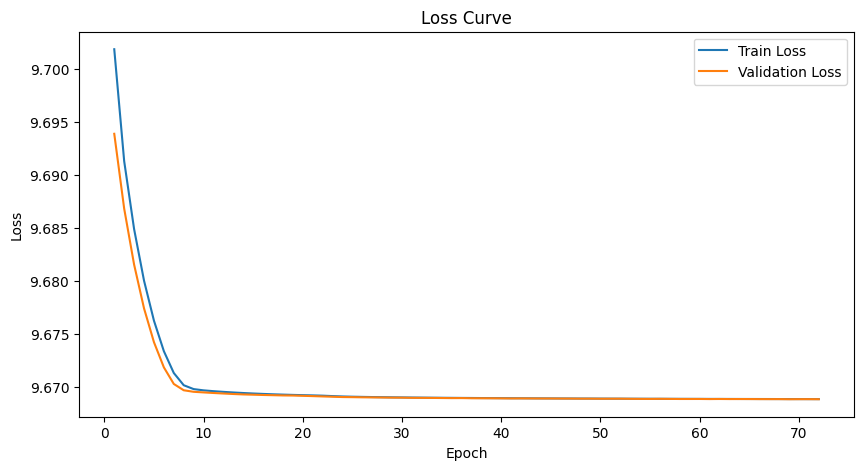

In [18]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

In [19]:
# Define concept dictionary
concept_dict = {'Emotion': ['Emotion', 'Feeling', 'Passion', 'Sentiment', 'Empathy', 'Expression', 'Drama', 'Pathos', 'Intensity', 'Conflict', 'Connection'],
                'Story': ['Story', 'Plot', 'Narrative', 'Script', 'Character', 'Arc', 'Theme', 'Conflict', 'Climax', 'Setting', 'Resolution']
               }


# Tokenize and Process Data with Labels
def tokenize_data_with_labels(reviews, labels):
    """
    Tokenize reviews and attach labels for evaluation.
    
    Args:
    - reviews (list of str): Input text data.
    - labels (list of int): Concept labels for evaluation.
    
    Returns:
    - TensorDataset: Tokenized input IDs, attention masks, and labels.
    """
    tokenized_data = tokenizer(reviews, padding=True, truncation=True, max_length=512, return_tensors="pt")
    input_ids = tokenized_data["input_ids"]
    attention_mask = tokenized_data["attention_mask"]
    label_ids = torch.tensor(labels, dtype=torch.long)
    return TensorDataset(input_ids, attention_mask, label_ids)


# Prepare Evaluation Dataset
eval_reviews = data['clean_text'].tolist()
eval_labels = data['final_concept'].apply(lambda x: list(concept_dict.keys()).index(x)).tolist()
eval_dataset = tokenize_data_with_labels(eval_reviews, eval_labels)

# Create DataLoader for Evaluation
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

In [20]:
# Evaluate Small Network
def evaluate_small_network(small_network, concept_classifier, data_loader, num_classes):
    """
    Evaluate the small network by measuring the concept classifier's accuracy 
    on the re-embedded outputs.

    Args:
    - small_network (nn.Module): The trained small network.
    - concept_classifier (nn.Module): The concept classifier.
    - data_loader (DataLoader): DataLoader for evaluation data.
    - num_classes (int): Number of concept classes.

    Returns:
    - accuracy (float): Concept classifier's accuracy on re-embedded outputs.
    - entropy (float): Average entropy of concept classifier predictions.
    """
    small_network.eval()
    concept_classifier.eval()

    correct = 0
    total = 0
    total_entropy = 0.0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating Small Network"):
            input_ids, attention_mask, labels = [x.to(device) for x in batch]

            # Forward pass through RoBERTa
            roberta_output = roberta_model(input_ids=input_ids, attention_mask=attention_mask)
            roberta_embeddings = roberta_output.last_hidden_state

            # Pass through Small Network
            reembedded_output = small_network(roberta_embeddings)

            # Concept Classifier predictions
            probs = concept_classifier(input_ids=None, attention_mask=None, embeddings=reembedded_output, return_probs=True)
            predictions = torch.argmax(probs, dim=-1)

            # Compute accuracy
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            # Compute entropy
            batch_entropy = -torch.sum(probs * torch.log(probs + 1e-9), dim=1).mean().item()
            total_entropy += batch_entropy * labels.size(0)

    accuracy = correct / total
    avg_entropy = total_entropy / total
    return accuracy, avg_entropy


# Run Evaluation
print("\nEvaluating Small Network...")
test_accuracy, avg_entropy = evaluate_small_network(small_network, concept_classifier, eval_loader, num_classes=2)

# Print Evaluation Metrics
print(f"Concept Classifier Accuracy on Re-embedded Outputs: {test_accuracy:.4f}")
print(f"Average Entropy of Concept Classifier Predictions: {avg_entropy:.4f}")



Evaluating Small Network...


Evaluating Small Network: 100%|███████████████████████████████████████████████| 264/264 [02:01<00:00,  2.17it/s]

Concept Classifier Accuracy on Re-embedded Outputs: 0.2101
Average Entropy of Concept Classifier Predictions: 0.0000
